In [56]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, make_scorer
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [72]:
X_test_full = pd.read_csv("./preprocessed/mergedTestData.csv")

algorithms = []
metrics = {}

scoring = {
  "precision_score": make_scorer(precision_score, zero_division=0),
  "recall_score": "recall",
  "roc_auc_score": "roc_auc",
  "f1_score": "f1",
  "accuracy_score": "accuracy",
}

def run_model(pipeline, param_grid, X_train, y_train, X_test, clfName):
  global metrics
  
  # Define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

  grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
    scoring=scoring, n_jobs=-1, cv=cv, refit="roc_auc_score")

  grid_result = grid.fit(X_train, y_train)
  print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

  # Evaluate the model
  p_pred = grid_result.predict_proba(X_test)

  # ROC Curve & PR 
  estimator = grid_result.best_estimator_
  RocCurveDisplay.from_estimator(estimator, X_train, y_train)
  PrecisionRecallDisplay.from_estimator(estimator, X_train, y_train)
  
  mean_fit_time = mean(grid_result.cv_results_.get('mean_fit_time'))
  mean_accuracy_score = mean(grid_result.cv_results_.get('mean_test_accuracy_score'))
  mean_precision_score = mean(grid_result.cv_results_.get('mean_test_precision_score'))
  mean_recall_score = mean(grid_result.cv_results_.get('mean_test_recall_score'))
  mean_roc_auc_score = mean(grid_result.cv_results_.get('mean_test_roc_auc_score'))
  mean_f1_score = mean(grid_result.cv_results_.get('mean_test_f1_score'))

  algorithms.append(clfName)
  metrics[clfName] = {}
  
  metrics[clfName]["fit_time"] = mean_fit_time
  metrics[clfName]["accuracy"] = mean_accuracy_score
  metrics[clfName]["precision"] = mean_precision_score
  metrics[clfName]["recall"] = mean_recall_score
  metrics[clfName]["roc_auc"] = mean_roc_auc_score
  metrics[clfName]["f1"] = mean_f1_score

  print("----------------- Metrics: -----------------")
  print("Mean Fit Time: " + str(mean_fit_time))
  print("Mean Accuracy Score: " + str(mean_accuracy_score))
  print("Mean Precision Score: " + str(mean_precision_score))
  print("Mean Recall Score: " + str(mean_recall_score))
  print("Mean Roc-Auc Score: " + str(mean_roc_auc_score))
  print("Mean F1 Score: " + str(mean_f1_score))

  resultData = {'Id': X_test_full['loan_id'], 'Predicted': p_pred[:,1]}
  result = pd.DataFrame(data=resultData)
  return result

def encode_df(df):
  columnsToEncode = list(df.select_dtypes(include=['object']))
  le = LabelEncoder()
  for feature in columnsToEncode:
      try:
          df[feature] = le.fit_transform(df[feature])
      except:
          print('Error encoding ' + feature)
  return df

def load_data():
  X_train_full = pd.read_csv("./preprocessed/mergedTrainData.csv")

  # Obtain target and predictors
  # features = ["duration","payments","last_balance","itr_balance_per_account", "frequency", "region","ratio entrepeneurs","average salary ","unemploymant_growth","criminality_growth","age_group"]
  # features = ['reached_negative_balance', 'ratio_RAB', 'credit_ratio', 'withdrawal_ratio', 'IC_mean', 'balance_min', 'mean_trans_profit', 'balance_mean', 'ratio_CC', 'CC_std', 'ratio_IC', 'withdrawal_max', 'WC_max']
  features = ['reached_negative_balance', 'RAB_mean', 'ratio_RAB', 'credit_ratio', 'balance_min', 'RAB_sum', 'mean_trans_profit', 'balance_mean', 'ratio_CC', 'CC_std', 'IC_min', 'CC_max', 'ratio_IC', 'withdrawal_max', 'WC_max', 'last_balance', 'CAB_mean']

  X_train = X_train_full[features]
  X_test = X_test_full[features]

  # Positive class now is 1 and negative class now is -1
  X_train_full.loc[X_train_full["status"] == 1, "status"] = 0
  X_train_full.loc[X_train_full["status"] == -1, "status"] = 1

  y_train = X_train_full.status

  return [X_train, X_test, y_train]

## Logistic Regression
Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

------- WITH UNDERSAMPLING -------
Best: 0.875666 using {'classification__C': 0.5, 'classification__class_weight': None, 'classification__penalty': 'l2', 'classification__solver': 'newton-cg', 'under__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.05307202047771878
Mean Accuracy Score: 0.8251385688684075
Mean Precision Score: 0.4699948846541984
Mean Recall Score: 0.7157023809523809
Mean Roc-Auc Score: 0.8569960579910977
Mean F1 Score: 0.5232098726436962


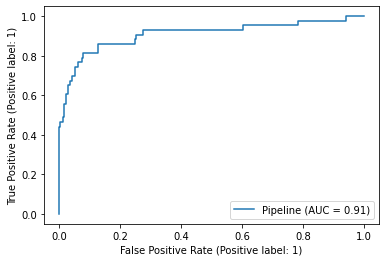

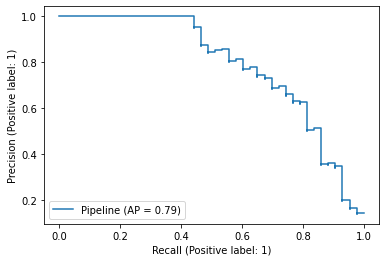

In [58]:
# Load data
[X_train, X_test, y_train] = load_data()

X_train = encode_df(X_train)
X_test = encode_df(X_test)

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 0.99, 'majority'],
          'classification__penalty': ['l2'],
          'classification__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
          'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
          'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "LogisticRegression_Undersampling")
results_df.to_csv("./results/logisticRegressionUndersampling.csv", index=None)

------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.874396 using {'classification__C': 0.2, 'classification__class_weight': None, 'classification__penalty': 'l2', 'classification__solver': 'newton-cg'}
----------------- Metrics: -----------------
Mean Fit Time: 0.028257536888122558
Mean Accuracy Score: 0.8644965277777777
Mean Precision Score: 0.5979228627672255
Mean Recall Score: 0.5730277777777777
Mean Roc-Auc Score: 0.8669199368018813
Mean F1 Score: 0.5015450904110605


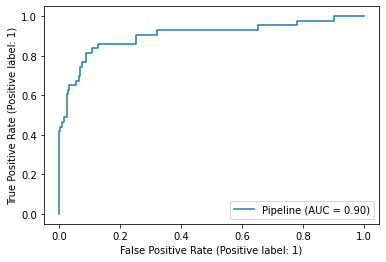

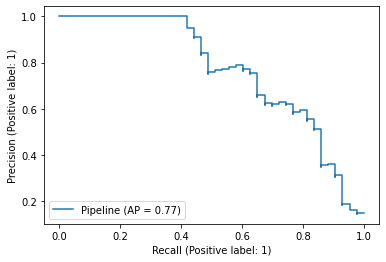

In [59]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
pipeline = Pipeline([('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

param_grid = {'classification__penalty': ['l2'],
          'classification__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
          'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
          'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "LogisticRegression")
results_df.to_csv("./results/logisticRegression.csv", index=None)


------- WITH OVERSAMPLING -------
Best: 0.875833 using {'classification__C': 0.5, 'classification__class_weight': None, 'classification__penalty': 'l2', 'classification__solver': 'newton-cg', 'smote__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.046549673780562385
Mean Accuracy Score: 0.8535955101126472
Mean Precision Score: 0.5102802506524495
Mean Recall Score: 0.7138015873015873
Mean Roc-Auc Score: 0.867869992441421
Mean F1 Score: 0.5583412217209026


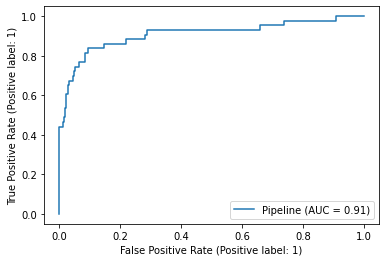

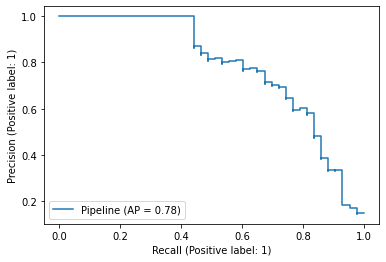

In [60]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid = {
        'smote__sampling_strategy': weights,
        'classification__penalty': ['l2'],
        'classification__C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
        'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
        'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "LogisticRegression_Oversampling")
results_df.to_csv("./results/logisticRegressionWithSMOTE.csv", index=None)

# Random Forest

------- WITH UNDERSAMPLING -------
Best: 0.916201 using {'classification__class_weight': None, 'classification__criterion': 'gini', 'classification__max_features': 'sqrt', 'classification__n_estimators': 250, 'under__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 1.1142625378789726
Mean Accuracy Score: 0.8676938657407407
Mean Precision Score: 0.58802387525631
Mean Recall Score: 0.7040972222222222
Mean Roc-Auc Score: 0.9019278181951793
Mean F1 Score: 0.5961905458399912


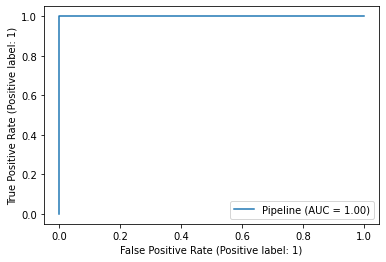

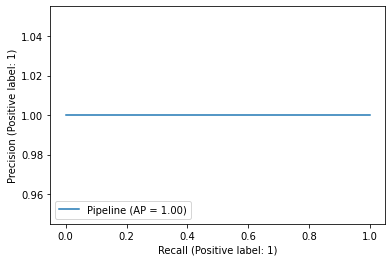

In [66]:
# https://stackoverflow.com/questions/30814231/using-the-predict-proba-function-of-randomforestclassifier-in-the-safe-and-rig
# https://rpmcruz.github.io/machine%20learning/2018/02/09/probabilities-trees.html

# Load data
[X_train, X_test, y_train] = load_data()

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classification', RandomForestClassifier(random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.5, 0.75, 0.9],
            'classification__n_estimators': [50, 150, 250],
            'classification__max_features': ['sqrt', 'auto'],
            'classification__criterion': ['gini', 'entropy'],
            'classification__class_weight': ["balanced", "balanced_subsample", None],}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "RandomForest_Undersampling")
results_df.to_csv("./results/randomForestUndersampling.csv", index=None)

------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.913159 using {'classification__class_weight': 'balanced', 'classification__criterion': 'gini', 'classification__max_features': 'sqrt', 'classification__n_estimators': 150}
----------------- Metrics: -----------------
Mean Fit Time: 1.1747997714413536
Mean Accuracy Score: 0.9197916666666666
Mean Precision Score: 0.8797839506172839
Mean Recall Score: 0.4588888888888889
Mean Roc-Auc Score: 0.9041359861845972
Mean F1 Score: 0.58200911228689


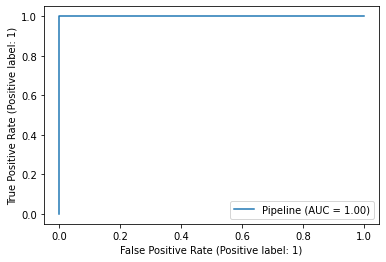

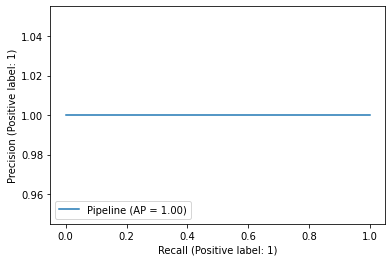

In [65]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
param_grid = {'classification__n_estimators': [50, 150, 250],
            'classification__max_features': ['sqrt', 'auto'],
            'classification__criterion': ['gini', 'entropy'],
            'classification__class_weight': ["balanced", "balanced_subsample", None],
            }


pipeline = Pipeline([('classification', RandomForestClassifier(random_state=0))])

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "RandomForest")
results_df.to_csv("./results/randomForest.csv", index=None)

------- WITH OVERSAMPLING -------
Best: 0.919831 using {'classification__class_weight': 'balanced', 'classification__criterion': 'gini', 'classification__max_features': 'sqrt', 'classification__n_estimators': 250, 'smote__sampling_strategy': 0.55}
----------------- Metrics: -----------------
Mean Fit Time: 1.4296829520552248
Mean Accuracy Score: 0.9131228843090401
Mean Precision Score: 0.7633940819126004
Mean Recall Score: 0.5911111111111111
Mean Roc-Auc Score: 0.9088946146874388
Mean F1 Score: 0.6380671797338464


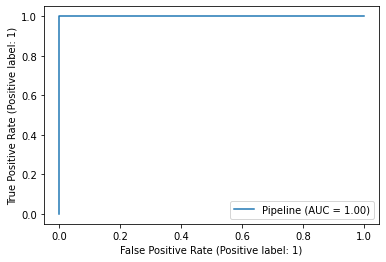

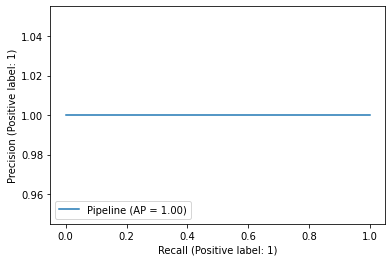

In [70]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classification', RandomForestClassifier(random_state=0))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid['smote__sampling_strategy'] = weights
results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "RandomForest_Oversampling")
results_df.to_csv("./results/randomForestWithSMOTE.csv", index=None)

# SVM
Applying Min-Max Scaling so that values are normalized (0-1).

In [71]:
def min_max_scaling(df, numeric_columns):
  # copy the dataframe
  df_norm = df.copy()
  # apply min-max scaling
  for column in numeric_columns:
      df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
      
  return df_norm


------- WITH UNDERSAMPLING -------
Best: 0.894850 using {'classification__C': 100, 'classification__gamma': 0.1, 'classification__kernel': 'rbf', 'under__sampling_strategy': 0.25}
----------------- Metrics: -----------------
Mean Fit Time: 0.06728426630156381
Mean Score Time: 0.029517713558106194
Mean Accuracy Score: 0.8227247503840246
Mean Precision Score: 0.3517349584094189
Mean Recall Score: 0.46435
Mean Roc-Auc Score: 0.840213246409675
Mean F1 Score: 0.34539079395768746


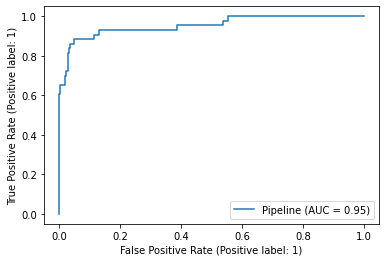

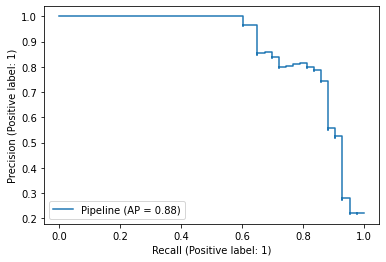

In [ ]:
# https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

# Load data
[X_train, X_test, y_train] = load_data()

numeric_features = list(X_train.select_dtypes(include=['int64', 'float64']))
X_train = min_max_scaling(X_train, numeric_features)
X_test = min_max_scaling(X_test, numeric_features)

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classification', SVC(probability=True, random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 0.99, 'majority'],
            'classification__C': [0.1, 1, 10, 100, 1000],
            'classification__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "SVM_Undersampling")
results_df.to_csv("./results/SVMUndersampling.csv", index=None)


------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.868979 using {'classification__C': 10, 'classification__gamma': 0.1, 'classification__kernel': 'rbf'}
----------------- Metrics: -----------------
Mean Fit Time: 0.04614121913909912
Mean Score Time: 0.027037396669387818
Mean Accuracy Score: 0.7263565188172043
Mean Precision Score: 0.3370589583655258
Mean Recall Score: 0.7957333333333333
Mean Roc-Auc Score: 0.8384342813051147
Mean F1 Score: 0.45714686109051716


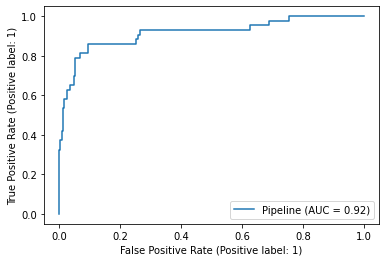

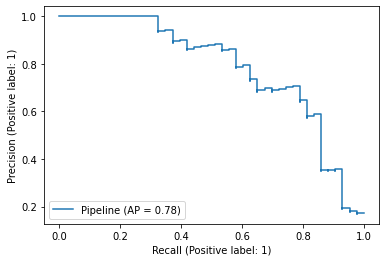

In [ ]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")

clf = Pipeline([('classification', SVC(probability=True, random_state=0))])

param_grid = {'classification__C': [0.1, 1, 10, 100, 1000],
              'classification__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "SVM")
results_df.to_csv("./results/SVM.csv", index=None)

In [ ]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classification', SVC(probability=True, random_state=0))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid['smote__sampling_strategy'] = weights

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "SVM_Oversampling")
results_df.to_csv("./results/SVMWithSMOTE.csv", index=None)

# Light GBM

------- WITH UNDERSAMPLING -------
Best: 0.892554 using {'classifier__learning_rate': 0.01, 'classifier__max_depth': 25, 'classifier__n_estimators': 110, 'classifier__num_leaves': 52, 'under__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.08109763807352678
Mean Score Time: 0.03315270563334594
Mean Accuracy Score: 0.833998609244325
Mean Precision Score: 0.42877551022766236
Mean Recall Score: 0.539050925925926
Mean Roc-Auc Score: 0.8526087748628258
Mean F1 Score: 0.4243807499053457


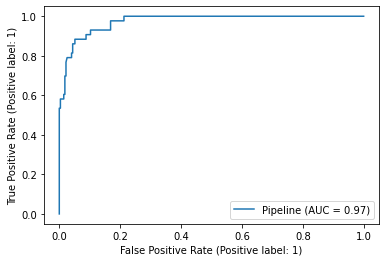

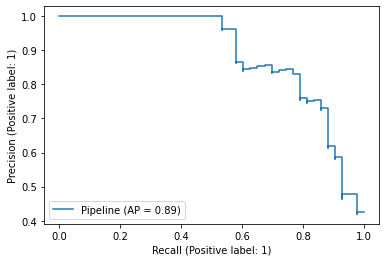

In [ ]:
# Load data
[X_train, X_test, y_train] = load_data()

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classifier', lgb.LGBMClassifier(random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 'majority'],
              'classifier__max_depth': [25, 50, 75],
              'classifier__learning_rate' : [0.01, 0.05, 0.1],
              'classifier__num_leaves': [int(x) for x in range(10, 100, 50)],
              'classifier__n_estimators': [int(x) for x in range(10, 200, 50)],
             }

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "LightGBM_Undersampling")
results_df.to_csv("./results/lightGBMUndersampling.csv", index=None)

In [ ]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
pipeline = Pipeline([('classifier', lgb.LGBMClassifier(random_state=0))])

param_grid = {'classifier__max_depth': [25, 50, 75],
              'classifier__learning_rate' : [0.01, 0.05, 0.1],
              'classifier__num_leaves': [int(x) for x in range(2, 100, 50)],
              'classifier__n_estimators': [int(x) for x in range(10, 200, 50)],
             }

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "LightGBM")
results_df.to_csv("./results/lightGBM.csv", index=None)

In [ ]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classifier', lgb.LGBMClassifier(random_state=0))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid['smote__sampling_strategy'] = weights

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test, "LightGBM_Oversampling")
results_df.to_csv("./results/lightGBMSMOTE.csv", index=None)

# Barplots of all algorithms

# Logistic Regression

### F1 Measure

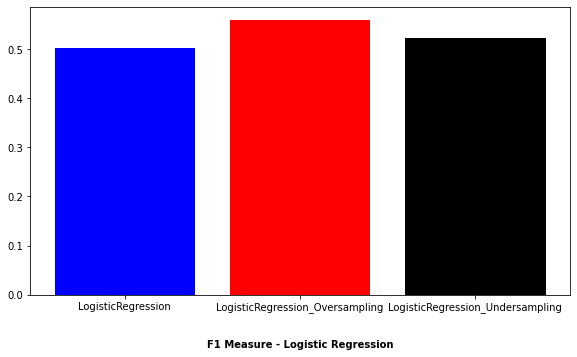

In [ ]:
algorithms = ("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling")

selectedMetric = "f1"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nF1 Measure - Logistic Regression", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Accuracy

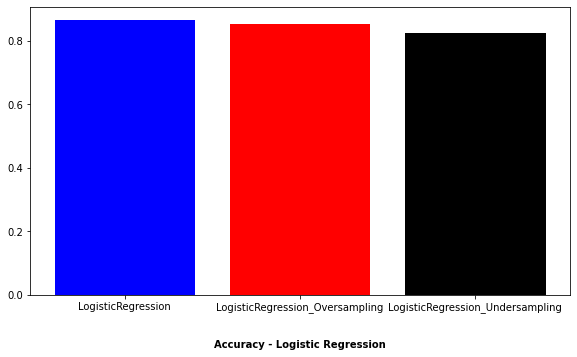

In [ ]:
algorithms = ("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling")

selectedMetric = "accuracy"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nAccuracy - Logistic Regression", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Precision

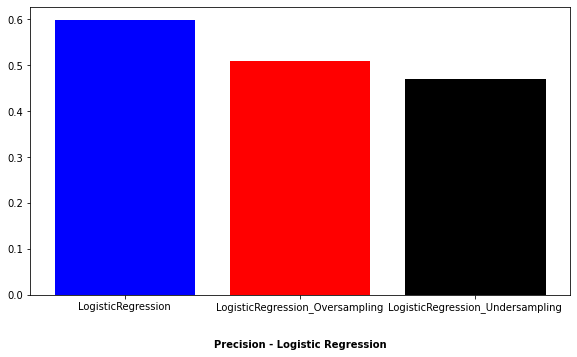

In [ ]:
algorithms = ("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling")

selectedMetric = "precision"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nPrecision - Logistic Regression", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Recall

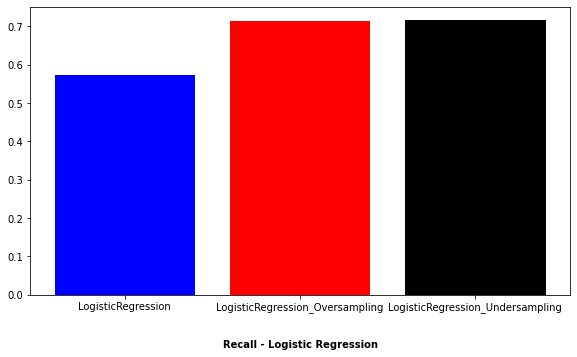

In [ ]:
algorithms = ("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling")

selectedMetric = "recall"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nRecall - Logistic Regression", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### ROC-AUC

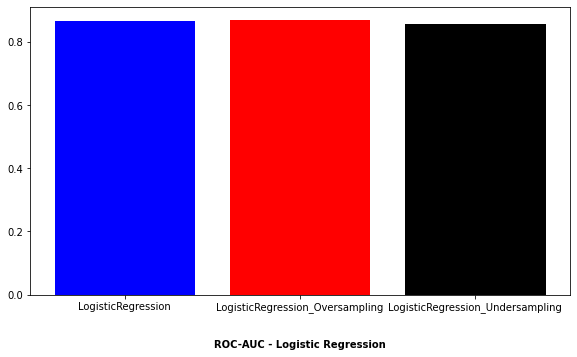

In [ ]:
algorithms = ("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling")

selectedMetric = "roc_auc"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nROC-AUC - Logistic Regression", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

# Random Forest

### F1 Measure

In [ ]:
algorithms = ("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling")

selectedMetric = "f1"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nF1 Measure - Random Forest", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Accuracy

In [ ]:
algorithms = ("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling")

selectedMetric = "accuracy"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nAccuracy - Random Forest", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Precision

In [ ]:
algorithms = ("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling")

selectedMetric = "precision"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nPrecision - Random Forest", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Recall

In [ ]:
algorithms = ("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling")

selectedMetric = "recall"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nRecall - Random Forest", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### ROC-AUC

In [ ]:
algorithms = ("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling")

selectedMetric = "roc_auc"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nROC-AUC - Random Forest", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

# SVM

### F1 Measure

In [ ]:
algorithms = ("SVM", "SVM_Oversampling", "SVM_Undersampling")

selectedMetric = "f1"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nF1 Measure - SVM", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Accuracy

In [ ]:
algorithms = ("SVM", "SVM_Oversampling", "SVM_Undersampling")

selectedMetric = "accuracy"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nAccuracy - SVM", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Precision

In [ ]:
algorithms = ("SVM", "SVM_Oversampling", "SVM_Undersampling")

selectedMetric = "precision"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nPrecision - SVM", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Recall

In [ ]:
algorithms = ("SVM", "SVM_Oversampling", "SVM_Undersampling")

selectedMetric = "recall"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nRecall - SVM", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### ROC-AUC

In [ ]:
algorithms = ("SVM", "SVM_Oversampling", "SVM_Undersampling")

selectedMetric = "roc_auc"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nROC-AUC - SVM", fontdict={"weight": "bold"})
plt.show()

# Light GBM

### F1 Measure

In [ ]:
algorithms = ("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling")

selectedMetric = "f1"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nF1 Measure - Light GBM", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Accuracy

In [ ]:
algorithms = ("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling")

selectedMetric = "accuracy"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nAccuracy - Light GBM", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Precision

In [ ]:
algorithms = ("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling")

selectedMetric = "Precision"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nPrecision - Light GBM", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### Recall

In [ ]:
algorithms = ("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling")

selectedMetric = "Recall"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nRecall - Light GBM", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()

### ROC-AUC

In [ ]:
algorithms = ("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling")

selectedMetric = "roc_auc"
values = [metrics[alg][selectedMetric] for alg in algorithms]

fig = plt.figure()
ax = fig.add_axes([0,0,1.25,1])
ax.bar(algorithms, values, color=['blue', 'red', 'black'])
plt.xlabel("\n\nROC-auc - Light GBM", fontdict={"weight": "bold"})
plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
plt.show()